In [ ]:
# !pip install selenium beautifulsoup4

In [17]:
# Import required libraries
from bs4 import BeautifulSoup
import requests 
from selenium import webdriver
import time
from datetime import timedelta
import pandas as pd
import sys
import numpy as np
import pickle


In [ ]:
from selenium.webdriver.chrome.options import Options
options = Options()

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup
import time

# Setup WebDriver
chrome_options = Options()
chrome_options.add_argument('--no-sandbox')
options.add_argument("start-maximized"); #// https://stackoverflow.com/a/26283818/1689770
options.add_argument("enable-automation"); #// https://stackoverflow.com/a/43840128/1689770
options.add_argument("--disable-dev-shm-usage"); #//https://stackoverflow.com/a/50725918/1689770
options.add_argument("--disable-browser-side-navigation"); #//https://stackoverflow.com/a/49123152/1689770
options.add_argument("--disable-gpu"); #//https://stackoverflow.com/questions/51959986/how-to-solve-selenium-chromedriver-timed-out-receiving-message-from-renderer-exc

chrome_service = Service('/usr/local/bin/chromedriver')
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

# Open the webpage
base_url = 'https://www.aljazeera.com'
driver.get(base_url + '/news')

# Initialize a list to hold the news articles
news_list = []
links = set()  # Initialize a set to hold the links of the fetched articles

def click_show_more():
    try:
        button = driver.find_element(By.CLASS_NAME, 'show-more-button')
        driver.execute_script("arguments[0].click();", button)  
        time.sleep(2) 
        return True
    except NoSuchElementException:
        return False 


prev_article_count = 0  # to check if new articles are loaded
while len(news_list) < 100:
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    articles = soup.find_all('article', class_='gc')
    
    if len(articles) == prev_article_count:  
        print("No new articles loaded. Exiting...")
        break
    
    prev_article_count = len(articles)
    
    print("Clicking Show More Button.")
    if not click_show_more():
        print("Show More Button not found! Exiting...")
        break

    for article in articles:
        news = {}
        title_tag = article.find('h3', class_='gc__title')
        if title_tag:
            news['title'] = title_tag.get_text(strip=True)
            link = title_tag.find('a')['href'] if title_tag.find('a') else None
            if link:
                if not link.startswith('http'):
                    link = base_url + link
                news['link'] = link
        else:
            continue  # skip this article if no title is found

        if link in links:  # skip if link is already in the list
            continue
        links.add(link)
        
        description_tag = article.find('div', class_='gc__excerpt')
        news['description'] = description_tag.get_text(strip=True) if description_tag else None

        if link:
            print("Navigating to:", link)
            driver.execute_script("window.open('');")  # new tab
            driver.switch_to.window(driver.window_handles[1])  # switch to the new tab
            driver.get(link)
            time.sleep(2)  # allow the page to load

            article_soup = BeautifulSoup(driver.page_source, 'html.parser')
            content_div = article_soup.find('div', class_='wysiwyg wysiwyg--all-content css-ibbk12')
            content_tags = content_div.find_all('p', recursive=False) if content_div else []
            content = ' '.join(tag.get_text(strip=True) for tag in content_tags)
            news['content'] = content if content_tags else None

            driver.close()  
            driver.switch_to.window(driver.window_handles[0])  

        news_list.append(news)

    print(f"Collected {len(news_list)} news articles.")

driver.quit()  

In [ ]:
news_df = pd.DataFrame(news_list)
news_df

In [ ]:
# save the news in csv files
news_df.to_csv('news_articles_04.csv', index=False)

In [2]:
df1 = pd.read_csv("Aljazeera_news/news_articles_01.csv")
df2 = pd.read_csv("Aljazeera_news/news_articles_02.csv")
df3 = pd.read_csv("Aljazeera_news/news_articles_03.csv")
df4 = pd.read_csv("Aljazeera_news/news_articles_04.csv")

In [3]:
frames = [df1,df2,df3,df4]
news_df = pd.concat(frames, ignore_index = True)
news_df

,title,link,description,content
0,Trump and ‘MAGA Re­pub­li­can ex­trem­ists’ th...,https://www.aljazeera.com/news/2023/9/28/trump...,Biden has un­der­scored the risk to democ­ra­c...,United States President Joe Biden has lashed o...
1,East Libya com­man­der Haf­tar in Moscow for t...,https://www.aljazeera.com/news/2023/9/28/east-...,"Krem­lin spokesper­son con­firms meet­ing, say...","Renegade general Khalifa Haftar, whose forces ..."
2,Be­larus says Pol­ish he­li­copter vi­o­lat­ed...,https://www.aljazeera.com/news/2023/9/28/belar...,Be­larus has re­peat­ed­ly ac­cused the EU mem...,Belarus has claimed that a Polish helicopter h...
3,"Pho­tos: In Brazil’s Ama­zon, drought af­fects...",https://www.aljazeera.com/gallery/2023/9/28/ph...,"With riv­er lev­els drop­ping, wa­ter trans­po...",NaN
4,Blinken meet­ing In­di­an coun­ter­part amid f...,https://www.aljazeera.com/news/2023/9/28/blink...,Cana­da PM says he re­ceived as­sur­ances that...,US Secretary of State Antony Blinken is meetin...
...,...,...,...,...
318,Pak­istan wants un­doc­u­ment­ed mi­grants to ...,https://www.aljazeera.com/news/2023/10/3/pakis...,Gov­ern­ment’s planned crack­down makes the fu...,Pakistan has ordered all undocumented immigran...
319,Twelve in­fants among 24 dead in a day at hos­...,https://www.aljazeera.com/news/2023/10/3/twelv...,"Deaths spark po­lit­i­cal storm, with the op­p...",Twelve infants have died in one day at a hospi...
320,At least 18 killed in blast at il­le­gal oil r...,https://www.aljazeera.com/news/2023/10/3/sever...,The blaze oc­curred when a home-made re­fin­er...,"At least 18 people, including a pregnant woman..."
321,Joe Biden’s son Hunter pleads not guilty to fe...,https://www.aljazeera.com/news/2023/10/3/joe-b...,US pres­i­dent’s son has be­come a favourite s...,US President Joe Biden’s sonHunterhas entered ...


In [4]:
# check missing values
news_df.isnull().sum()

title           0
link            0
description     0
content        29
dtype: int64

In [5]:
news_df=news_df.dropna()

In [6]:
# duplicated valus
duplicated_count = news_df.duplicated().sum()
print(f"Number of duplciated values are {duplicated_count}")

Number of duplciated values are 81


In [7]:
news_df = news_df.drop_duplicates()

In [8]:
from Cleaning import NewsPreprocessor

2023-10-04 12:28:31.231099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
import dask.dataframe as dd

# Instantiate the preprocessing class
preprocessor = NewsPreprocessor()

# Convert the pandas dataframe to a Dask dataframe
dask_df = dd.from_pandas(news_df, npartitions=4)  

dask_df['content'] = dask_df['content'].map_partitions(lambda df: df.apply(lambda x: preprocessor.preprocess(x))).\
compute(scheduler='multiprocessing')

# Convert back to pandas dataframe 
news_df = dask_df.compute()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-10-04 12:28:52.441974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
with open('Tokenizer_folder/deeplearning_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [26]:
max_length = 1037

#Tokenize the content_news using the loaded tokenizer
content_news_sequences = loaded_tokenizer.texts_to_sequences(content_news)

# Pad the tokenized content_news
# Using the same max_length as you did before ensures consistency
content_news_padded = pad_sequences(content_news_sequences, padding='post', maxlen=max_length)

In [20]:
from tensorflow.keras.models import load_model

## Deep Learning Modeling 

### Running LSTM 

In [21]:
LSTM_model = load_model("Saved_models/lstm_model.h5")

In [35]:
LSTM_predictions = LSTM_model.predict(content_news_padded)

7/7 [==============================] - 5s 626ms/step


In [36]:
LSTM_predictions

array([[0.96876764],
       [0.8925049 ],
       [0.9262428 ],
       [0.7692209 ],
       [0.949687  ],
       [0.5025139 ],
       [0.221819  ],
       [0.5984937 ],
       [0.9677513 ],
       [0.8612051 ],
       [0.9714495 ],
       [0.95732886],
       [0.9707777 ],
       [0.9980418 ],
       [0.83910435],
       [0.95019233],
       [0.97468114],
       [0.9580656 ],
       [0.8914013 ],
       [0.6266974 ],
       [0.9446866 ],
       [0.5183707 ],
       [0.9672784 ],
       [0.9580533 ],
       [0.99639505],
       [0.9421605 ],
       [0.9267768 ],
       [0.9893092 ],
       [0.98779076],
       [0.991689  ],
       [0.9802404 ],
       [0.9621944 ],
       [0.99264157],
       [0.98271334],
       [0.8511238 ],
       [0.37548563],
       [0.9233729 ],
       [0.8746194 ],
       [0.94052845],
       [0.9891771 ],
       [0.95801806],
       [0.9816291 ],
       [0.96540064],
       [0.99509835],
       [0.85950196],
       [0.9204764 ],
       [0.9666192 ],
       [0.969

In [37]:
predicted_labels = [0 if prob >= 0.5 else 1 for prob in predictions]

news_df["predicted_label"] = predicted_labels
news_df.head()

,title,link,description,content,predicted_label
0,Trump and ‘MAGA Re­pub­li­can ex­trem­ists’ th...,https://www.aljazeera.com/news/2023/9/28/trump...,Biden has un­der­scored the risk to democ­ra­c...,united state president joe biden lashed republ...,0
1,East Libya com­man­der Haf­tar in Moscow for t...,https://www.aljazeera.com/news/2023/9/28/east-...,"Krem­lin spokesper­son con­firms meet­ing, say...",renegade general khalifa haftar whose force do...,0
2,Be­larus says Pol­ish he­li­copter vi­o­lat­ed...,https://www.aljazeera.com/news/2023/9/28/belar...,Be­larus has re­peat­ed­ly ac­cused the EU mem...,belarus claimed polish helicopter violated air...,0
4,Blinken meet­ing In­di­an coun­ter­part amid f...,https://www.aljazeera.com/news/2023/9/28/blink...,Cana­da PM says he re­ceived as­sur­ances that...,u secretary state antony blinken meeting india...,0
5,US Visa Waiv­er Pro­gram: Why Arab Amer­i­cans...,https://www.aljazeera.com/news/2023/9/28/us-vi...,Ad­vo­cates say US gov­ern­ment is turn­ing bl...,washington dc biden administration decision al...,0


0    200
1     13
Name: predicted_label, dtype: int64


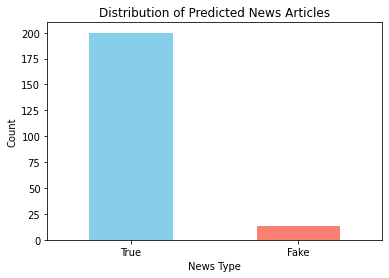

In [38]:
import matplotlib.pyplot as plt

# Assuming 'predicted_labels' is the list/array of your predictions
news_df["predicted_label"] = predicted_labels

# Count the occurrences of each label
label_counts = news_df["predicted_label"].value_counts()
print(label_counts)

label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Predicted News Articles')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['True', 'Fake'], rotation=0) 
plt.show()